In [2]:
import pandas as pd

In [2]:
# Download the data (public github)
!wget -N https://github.com/fiddler-labs/p2p-lending-data/raw/refs/heads/master/raw_data/accepted_2007_to_2018Q3.csv.gz

'wget' is not recognized as an internal or external command,
operable program or batch file.


In [3]:
df = pd.read_csv('accepted_2007_to_2018Q3.csv.gz')

C:\Users\blake\AppData\Local\Temp\ipykernel_19856\2329708970.py:1: DtypeWarning: Columns (0,19,49,59,118,129,130,131,134,135,136,139,145,146,147) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('accepted_2007_to_2018Q3.csv.gz')


In [4]:
pd.set_option('display.max_columns', None)
print(df.columns.tolist())

['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate', 'installment', 'grade', 'sub_grade', 'emp_title', 'emp_length', 'home_ownership', 'annual_inc', 'verification_status', 'issue_d', 'loan_status', 'pymnt_plan', 'url', 'desc', 'purpose', 'title', 'zip_code', 'addr_state', 'dti', 'delinq_2yrs', 'earliest_cr_line', 'fico_range_low', 'fico_range_high', 'inq_last_6mths', 'mths_since_last_delinq', 'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'initial_list_status', 'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'last_pymnt_d', 'last_pymnt_amnt', 'next_pymnt_d', 'last_credit_pull_d', 'last_fico_range_high', 'last_fico_range_low', 'collections_12_mths_ex_med', 'mths_since_last_major_derog', 'policy_code', 'application_type', 'annual_inc_joint', 'dti_joint', 'verification_status_joint', 'acc_now_delinq',

In [5]:
df.groupby(['loan_status']).size()

loan_status
Charged Off                                             254777
Current                                                 822105
Default                                                     32
Does not meet the credit policy. Status:Charged Off        761
Does not meet the credit policy. Status:Fully Paid        1988
Fully Paid                                             1011841
In Grace Period                                          12458
Late (16-30 days)                                         5442
Late (31-120 days)                                       22852
dtype: int64

In [6]:
df = df[df['loan_status'].isin(['Charged Off', 'Fully Paid'])]

In [7]:
df.groupby(['loan_status']).size()

loan_status
Charged Off     254777
Fully Paid     1011841
dtype: int64

**Your code below**

*   Reduce the overall data set to 200K rows or less
*   Split your data for training / testing
*   Build at least two models with `loan_status` as the target
*   Report on the model's performance
*   Report on the model's drivers (feature importance / effects)

Plant 2 flaws in this notebook.  Do not "give away" the answers here.  This notebook should appear, at first glance, to create a viable model.

Make a note of your flaws and be prepared to talk about how the code / results look when they are "fixed".  You will need to talk about those in the final presentation.

Imports

In [3]:
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

from IPython.display import clear_output
from datetime import datetime

from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score, train_test_split

%matplotlib inline
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.5)
sns.set_style('ticks')

from os import listdir
from os.path import isfile, join
import warnings
warnings.filterwarnings('ignore')

We see that there are over a million rows in the dataset. For processing purposes, we found that working with a random sample of this large dataset was very useful in the initial stages of data processing.

In [9]:
loan_df = df.sample(frac=.05, random_state=0)

print('Total Number of Rows:', '{:,}'.format(loan_df.shape[0]))
print('Total Number of Columns:', '{:,}'.format(loan_df.shape[1]))

Total Number of Rows: 63,331
Total Number of Columns: 151


Missing Values: Visualization and Feature Selection
Checking for and Cleaning Missing Data
A visual check at the data set shows that there are several columns with a large number of null values.

In [10]:
def get_missing_values_table(df):
    #Number of null values by column
    missing_values_df = pd.DataFrame(df.isnull().sum(),columns=['Missing_Count'])
    
    #Portion of null values by column
    missing_values_df['Portion_Missing'] = missing_values_df['Missing_Count']/df.shape[0]

    #Sort by Missing_Count
    missing_values_df = missing_values_df.sort_values(by='Missing_Count',ascending=False)  
    
    return missing_values_df

missing_values_df = get_missing_values_table(loan_df)
missing_values_df.head()

,Missing_Count,Portion_Missing
next_pymnt_d,63331,1.000000
member_id,63331,1.000000
orig_projected_additional_accrued_interest,63188,0.997742
sec_app_mths_since_last_major_derog,63101,0.996368
hardship_length,63100,0.996352


Number of Columns with under 15% missing values: 93


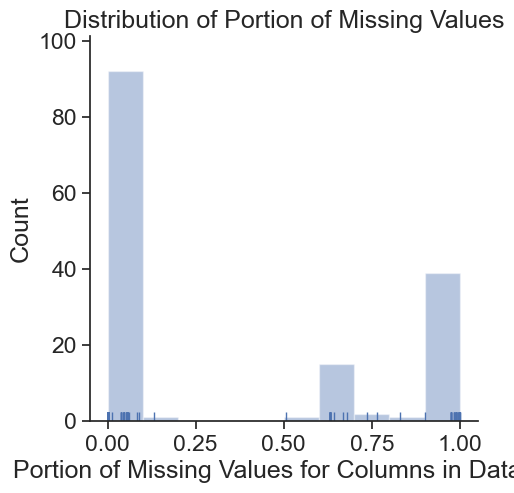

In [11]:
print('Number of Columns with under 15% missing values:', 
      missing_values_df[missing_values_df['Portion_Missing']<=0.15].shape[0])

#Plot the distribution of Portions of missing values for the columns
fig, ax = plt.subplots(figsize=(5,5))
sns.distplot(missing_values_df['Portion_Missing'], bins=10, kde=False, rug=True)
ax.set_title('Distribution of Portion of Missing Values')
ax.set_xlabel('Portion of Missing Values for Columns in Dataset')
ax.set_ylabel('Count')
sns.despine()

Upon first glance, we see that there are many columns that do have a reasonably low level of missingess: 93 columns that have less than 15% missing values.

There seems to be a small concentration of columns between 60-70% missing values. Below, we explore this and see that there are 11 columns with almost exactly the same number of missing values. Furthermore, using the issue_d column (which indicates the date the date in which the loan was issued), we found that these variables had missing values for all loans issued prior to 2015-12-01. It's possible that the Lending Club simply did not record or use this particular information from potential borrowers until a later date. We have chosen not to include these columns because:

there are many other columns that capture similar credit-related information; and

we want to keep the older loan information in the dataset, especially since we are looking at only completed loans. Removing the older samples would greatly reduce our sample size.

In [12]:
missing_grp = missing_values_df[(missing_values_df['Portion_Missing']>=0.6)&(missing_values_df['Portion_Missing']<=0.7)]
display(missing_grp)

missing_columns = missing_grp.index

earliest_date = []
for column in missing_columns:
    earliest_date.append(min(loan_df[~loan_df[column].isnull()]['issue_d'])) 

display(pd.DataFrame({'Column':missing_columns,
                      'Earliest issue_d for which column value is not null':earliest_date}))

,Missing_Count,Portion_Missing
il_util,43040,0.679604
mths_since_recent_revol_delinq,42276,0.667540
mths_since_rcnt_il,40611,0.641250
all_util,40031,0.632092
total_cu_tl,40030,0.632076
max_bal_bc,40030,0.632076
inq_last_12m,40030,0.632076
open_rv_12m,40030,0.632076
total_bal_il,40030,0.632076
open_il_24m,40030,0.632076


,Column,Earliest issue_d for which column value is not null
0,il_util,Apr-2016
1,mths_since_recent_revol_delinq,Apr-2012
2,mths_since_rcnt_il,Apr-2016
3,all_util,Apr-2016
4,total_cu_tl,Apr-2016
5,max_bal_bc,Apr-2016
6,inq_last_12m,Apr-2016
7,open_rv_12m,Apr-2016
8,total_bal_il,Apr-2016
9,open_il_24m,Apr-2016


Before going on, we will remove many columns from the dataset. We have made decisions on which columns to initially drop from our DataFrame based on the variable descriptions in the Lending Club data dictionary, applicability of each feature to our model, and the level of missingness observed.:

There are 3 columns relating to the lending club's borrower identification (id, member_id, and url), which contain 100% missing values. next_pymnt_d also has all missing values: since these loans have been completed, there is no data for the next payment date. We exclude these four columns.

pymnt_plan, out_prncp, out_prncp_inv, and policy_code have only one unique value each so they will not be useful in our model. We exclude these columns.

As we saw above following columns all had the same large number of missing values, and we determined that all of the loans issued prior to Apr-2016 have null values for these variables. This could be because the lending club did not previously store/analyze these columns but made a recent change. We have chosen to drop these variables since other variables cover similar information and we prefer to keep as many of the samples as possible. The 11 columns are: open_acc_6m, open_act_il, open_il_12m, open_il_24m, total_bal_il, open_rv_12m, open_rv_24m, max_bal_bc, inq_fi, total_cu_tl, inq_last_12m. The following 3 columns had slightly more missing data but followed the same trend of newer-only data, so we also exclude them: il_util, all_util, mths_since_rcnt_il

We exclude num_tl_120dpd_2m and num_tl_30dpd because data dictionary indicates these were "udpated in past 2 months" (i.e. we wouldn't have these values at loan origination)

Hardship-related variables: There are a number of columns relating to borrowers who were on a hardship plan. For borrowers who were not on a hardship plan, the data are coded as missing. We will remove these variables, since we do not know at the point of loan origination whether or not the borrower will have a hardship. This is the list of hardshp-related columns based on the data dictionary: deferral_term,hardship_amount,hardship_dpd, hardship_end_date, hardship_flag, hardship_last_payment_amount, hardship_length, hardship_loan_status, hardship_payoff_balance_amount, hardship_reason, hardship_start_date, hardship_status, hardship_type, orig_projected_additional_accrued_interest, payment_plan_start_date.

We exclude desc, title and emp_title because these are string variables with borrower-provided text; the Lending Club has categorized this information in other columns.

We exclude columns related to the specifics of loan settlement, something we wouldn't know at the time of funding (and in our case these are very trivial features relating to a loan being charged off): debt_settlement_flag, debt_settlement_flag_date,settlement_amount, settlement_date, settlement_percentage, settlement_status, settlement_term, recoveries, collection_recovery_fee

We also excluded the following colums since they include information relating to the specifics of the Lending Club's loan (including information on late fees received on the lending club loan, last payment amount on the lending club loan, etc.), which also wouldn't be available at the time of the funding decision: funded_amnt, funded_amnt_inv, last_pymnt_amnt, out_prncp, out_prncp_inv, total_pymnt, total_pymnt_inv, total_rec_int, total_rec_late_fee, total_rec_prncp, last_pymnt_d, last_credit_pull_d, disbursement_method

We exclude initial_list_status based on research into the meaning of this column. "On September 28th, 2012, LendingClub announced that, as opposed to its standard fractional investment business model, it would begin setting aside some loans that could only be purchased in their entirety–or as whole loans. Part of that announcement were promises that whole loans would be chosen randomly from the general pool and that anyone would be able to participate in the whole loan program"(https://www.lendacademy.com/lending-club-whole-loan-program-one-year-later/). Because the whole loans are randomly-chosen, they should not provide additional information. Also, we noticed that there are more "whole"-category loans in later years.

Text descriptions of the variables that remain in our model after cleaning are provided at the end of this page.

There is also 'fico_range_high','fico_range_low','last_fico_range_high','last_fico_range_low','sec_app_fico_range_high','sec_app_fico_range_low' that we are dropping

In [13]:
exclude = ['id', 'member_id', 'url', 'next_pymnt_d', 'pymnt_plan', 'out_prncp',
           'out_prncp_inv', 'policy_code', 'open_acc_6m', 'open_act_il', 'open_il_12m',
           'open_il_24m', 'total_bal_il', 'open_rv_12m', 'open_rv_24m', 'max_bal_bc',
           'inq_fi', 'total_cu_tl', 'inq_last_12m', 'il_util', 'all_util','mths_since_rcnt_il',
           'num_tl_120dpd_2m', 'num_tl_30dpd', 'deferral_term', 'hardship_amount',
           'hardship_dpd', 'hardship_end_date', 'hardship_flag', 'hardship_last_payment_amount',
           'hardship_length', 'hardship_loan_status', 'hardship_payoff_balance_amount',
           'hardship_reason', 'hardship_start_date', 'hardship_status', 'hardship_type',
           'orig_projected_additional_accrued_interest', 'payment_plan_start_date',
           'desc', 'title', 'emp_title', 'debt_settlement_flag', 'debt_settlement_flag_date',
           'settlement_amount', 'settlement_date', 'settlement_percentage', 'settlement_status',
           'settlement_term', 'recoveries', 'collection_recovery_fee', 'funded_amnt',
           'funded_amnt_inv', 'last_pymnt_amnt', 'out_prncp', 'out_prncp_inv',  'total_pymnt',
           'total_pymnt_inv', 'total_rec_int', 'total_rec_late_fee', 'total_rec_prncp',
           'last_pymnt_d',  'last_credit_pull_d', 'disbursement_method', 'initial_list_status',
           'fico_range_high','fico_range_low','last_fico_range_high','last_fico_range_low','sec_app_fico_range_high','sec_app_fico_range_low' ]

potential_features = np.setdiff1d(loan_df.columns.tolist(), exclude)

print(len(potential_features))
print(sorted(potential_features))

loan_df = loan_df[potential_features]

82
['acc_now_delinq', 'acc_open_past_24mths', 'addr_state', 'annual_inc', 'annual_inc_joint', 'application_type', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'chargeoff_within_12_mths', 'collections_12_mths_ex_med', 'delinq_2yrs', 'delinq_amnt', 'dti', 'dti_joint', 'earliest_cr_line', 'emp_length', 'grade', 'home_ownership', 'inq_last_6mths', 'installment', 'int_rate', 'issue_d', 'loan_amnt', 'loan_status', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc', 'mths_since_last_delinq', 'mths_since_last_major_derog', 'mths_since_last_record', 'mths_since_recent_bc', 'mths_since_recent_bc_dlq', 'mths_since_recent_inq', 'mths_since_recent_revol_delinq', 'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl', 'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'num_op_rev_tl', 'num_rev_accts', 'num_rev_tl_bal_gt_0', 'num_sats', 'num_tl_90g_dpd_24m', 'num_tl_op_past_12m', 'open_acc', 'pct_tl_nvr_dlq', 'percent_bc_gt_75', 'pub_rec', 'pub_rec_bankrupt

We visualize missingness on the remaining columns and see that many of the columns are new from 2012-08-01 and later. We choose to work with data from this date and beyond since the data from prior to this date is only a small subset of our data.

In [14]:
def view_missingness_by_issue_d(df):
    missing_values_df = get_missing_values_table(df)
    earliest_date = []
    cols_with_missing_vals = missing_values_df[(missing_values_df.Portion_Missing<1) &
                                           (missing_values_df.Missing_Count >0)].index

    for column in cols_with_missing_vals:
        earliest_date.append(min(loan_df[~loan_df[column].isnull()]['issue_d'])) 

    df = pd.DataFrame({'Column':cols_with_missing_vals,
                      'Earliest issue_d for which column value is not null':earliest_date})
    
    return df.sort_values(by='Earliest issue_d for which column value is not null', ascending=False)

view_missingness_by_issue_d(loan_df).head(15)

,Column,Earliest issue_d for which column value is not null
0,sec_app_mths_since_last_major_derog,Apr-2017
6,revol_bal_joint,Apr-2017
1,sec_app_revol_util,Apr-2017
9,sec_app_open_act_il,Apr-2017
8,sec_app_open_acc,Apr-2017
7,sec_app_num_rev_accts,Apr-2017
10,sec_app_mort_acc,Apr-2017
5,sec_app_chargeoff_within_12_mths,Apr-2017
4,sec_app_collections_12_mths_ex_med,Apr-2017
3,sec_app_earliest_cr_line,Apr-2017


Now, we see that there are columns relating to details of applications that have multiple borrowers (co-borrowers). These columns only have non-null values from issue dates of 2017-03-01 and later (or 2015-10-01 and later for 'dti_joint', 'annual_inc_joint', and 'verification_status_joint'), so we remove these columns. We remove all of these columns:

annual_inc_joint, dti_joint, revol_bal_joint, sec_app_chargeoff_within_12_mths, sec_app_collections_12_mths_ex_med, sec_app_earliest_cr_line, sec_app_inq_last_6mths, sec_app_mort_acc, sec_app_mths_since_last_major_derog, sec_app_num_rev_accts, sec_app_open_acc, sec_app_open_act_il, sec_app_revol_util, verification_status_joint]

Note that we still do have the application_type variable, which is a simple binary indicator of whether or not the application had co-borrowers.

In [15]:
coborrower_cols =  ['annual_inc_joint', 'dti_joint', 'revol_bal_joint',
                    'sec_app_chargeoff_within_12_mths', 'sec_app_collections_12_mths_ex_med',
                    'sec_app_earliest_cr_line', 'sec_app_inq_last_6mths', 'sec_app_mort_acc',
                    'sec_app_mths_since_last_major_derog', 'sec_app_num_rev_accts',
                    'sec_app_open_acc', 'sec_app_open_act_il', 'sec_app_revol_util',
                    'verification_status_joint']

potential_features = np.setdiff1d(loan_df.columns.tolist(), coborrower_cols)
loan_df = loan_df[potential_features]

After removing these colummns, we take another look at the remaining columns that have missing values.

In [16]:
display(view_missingness_by_issue_d(loan_df))

get_missing_values_table(loan_df).head(15)

,Column,Earliest issue_d for which column value is not null
22,total_rev_hi_lim,Apr-2013
15,num_op_rev_tl,Apr-2013
33,num_bc_sats,Apr-2013
32,num_sats,Apr-2013
27,tot_hi_cred_lim,Apr-2013
26,tot_cur_bal,Apr-2013
25,tot_coll_amt,Apr-2013
24,avg_cur_bal,Apr-2013
23,total_il_high_credit_limit,Apr-2013
1,mths_since_recent_bc_dlq,Apr-2013


,Missing_Count,Portion_Missing
mths_since_last_record,52542,0.829641
mths_since_recent_bc_dlq,48435,0.764791
mths_since_last_major_derog,46643,0.736496
mths_since_recent_revol_delinq,42276,0.667540
mths_since_last_delinq,32047,0.506024
mths_since_recent_inq,8311,0.131231
mo_sin_old_il_acct,5212,0.082298
emp_length,3545,0.055976
pct_tl_nvr_dlq,3428,0.054128
num_accts_ever_120_pd,3423,0.054049


We notice that many of the columns only have non-null values for issue dates of 2013-04-01 and later, so we remove the samples that have issue_dates prior to this. We see that this only reduces our sample size by a small amount.

In [17]:
print("Number of rows in dataset: {}".format (loan_df.shape[0]))

loan_df = loan_df[pd.to_datetime(loan_df['issue_d'], format='%b-%Y') >= pd.to_datetime('03/01/2013', format='%m/%d/%Y')]


print("Number of rows in dataset after removing loans issued prior to 2013-04-01: {}"\
      .format (loan_df.shape[0]))

Number of rows in dataset: 63331
Number of rows in dataset after removing loans issued prior to 2013-04-01: 57963


**Taking another look at missingness: **

In [18]:
display(view_missingness_by_issue_d(loan_df))

get_missing_values_table(loan_df).head(15)

,Column,Earliest issue_d for which column value is not null
0,mths_since_last_record,Apr-2013
1,mths_since_recent_bc_dlq,Apr-2013
2,mths_since_last_major_derog,Apr-2013
3,mths_since_recent_revol_delinq,Apr-2013
4,mths_since_last_delinq,Apr-2013
5,mths_since_recent_inq,Apr-2013
6,emp_length,Apr-2013
7,mo_sin_old_il_acct,Apr-2013
8,bc_util,Apr-2013
9,percent_bc_gt_75,Apr-2013


,Missing_Count,Portion_Missing
mths_since_last_record,47471,0.818988
mths_since_recent_bc_dlq,43545,0.751255
mths_since_last_major_derog,41638,0.718355
mths_since_recent_revol_delinq,37790,0.651968
mths_since_last_delinq,28761,0.496196
mths_since_recent_inq,5603,0.096665
emp_length,3378,0.058279
mo_sin_old_il_acct,1705,0.029415
bc_util,633,0.010921
percent_bc_gt_75,605,0.010438


Pre-Processing of Selected Columns

Great! The missingness for the remaining columns is much more reasonable, but there are still a few columns with large portions of missing values. Consulting the data dictionary reveals a plausible explanation for this:

Many of the columns that still have high levels of missingness are those which measure "months since" something happened. For example, months_since_recent_bc_dlq measures "Months since most recent bankcard delinquency." Thus, it's likely that the "missing" values are not truly missing data; rather, the borrower has simply never had a bankcard delinquency. Thus, we choose to process the "month since" columns by filling the null values with the maximum observed value + 1, so that the borrowers who have never had delinquencies just have the largest value for number of months since delinquency. Since we will be using decision-tree based models, this is an appropriate approach that allows the decision tree to separate the borrowers who have had recent delinquencies from those who have not.

We also process a few other columns below:

Re-categorize emp_length so that there are fewer categories
Cast revol_util to float
Change loan_grade and grade values to numerical rankings (i.e., an ordinal variable with the lowest grade/subgrade indicating the least-risky loans)
credit_line_age and earliest_cr_line
int_rate
zip_code
fully_paid and loan_status

In [19]:
print('emp_length value counts: \n{}\n'.format(loan_df.emp_length.value_counts()))

emp_length value counts: 
emp_length
10+ years    19323
2 years       5167
< 1 year      4683
3 years       4586
1 year        3757
5 years       3518
4 years       3437
8 years       2689
6 years       2648
7 years       2478
9 years       2299
Name: count, dtype: int64



In [20]:
def process_emp_length(df):
    df_new = df.copy()
    #0-1 years inclues: null, None, < 1 year, 1 year
    df_new['emp_length'] = df_new['emp_length'].fillna('0-1 years')
    df_new['emp_length'] = np.where(df_new['emp_length'].isin([np.nan,None,'< 1 year','1 year']),
                                     '0-1 years',df_new['emp_length'])
    #2-4 years inclues: 2 years, 3 years, 4 years
    df_new['emp_length'] = np.where(df_new['emp_length'].isin(['2 years','3 years','4 years']),
                                     '2-4 years',df_new['emp_length'])
    
    #5-9 years inclues: 5 years, 6 years, 7 years, 8 years, 9 years
    df_new['emp_length'] = np.where(df_new['emp_length'].isin(['5 years','6 years','7 years','8 years','9 years']),
                                     '5-9 years',df_new['emp_length'])
    #10+ years includes 10+ years (no change)
    return df_new

def process_revol_util(df):
    df_new = df.copy()
    
    df_new['revol_util'] = df_new['revol_util'].fillna(-100)
    df_new['revol_util'] = df_new['revol_util'].apply(lambda x: float(str(x).split('%')[0])/100)
    df_new['revol_util'] = np.where(df_new['revol_util']==-1.0,np.nan,df_new['revol_util'])
    
    return df_new

def process_month_since_cols(df):
    df_new = df.copy()

    mo_since_cols = ['mo_sin_old_il_acct','mths_since_last_delinq','mths_since_last_major_derog',
                     'mths_since_last_record','mths_since_recent_bc_dlq','mths_since_recent_inq',
                     'mths_since_recent_revol_delinq','mo_sin_old_rev_tl_op','mths_since_recent_bc',
                     'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl']

    for col in mo_since_cols:
        df_new[col].fillna(df_new[col].max()+1, inplace=True)
    
    return df_new

def process_loan_grades(df):
    df_new = df.copy()
    
    # turn sub_grade into ordinal mapping
    sorted_subgrades = sorted(df.sub_grade.unique())
    subgrade_dict = dict(zip(sorted_subgrades, range(len(sorted_subgrades))))
    df_new['sub_grade'] = df_new['sub_grade'].map(subgrade_dict)
    
    # turn grade into ordinal mapping
    sorted_grades = sorted(df.grade.unique())
    grade_dict = dict(zip(sorted_grades, range(len(sorted_grades))))
    df_new['grade'] = df_new['grade'].map(grade_dict)
    return df_new
    
    
def process_loan_cols(df):
    df_processed = process_emp_length(df)
    df_processed = process_revol_util(df_processed)
    df_processed = process_month_since_cols(df_processed)
    df_processed = process_loan_grades(df_processed)
    
    #add credit_line_age
    df_processed['issue_d'] = pd.to_datetime(df_processed['issue_d'], format='%b-%Y')
    df_processed['earliest_cr_line'] = pd.to_datetime(df_processed['earliest_cr_line'])
    df_processed['credit_line_age'] = df_processed['issue_d'] - pd.to_datetime(df_processed['earliest_cr_line'])
    df_processed = df_processed.drop(columns='earliest_cr_line')

    #process int_rate, zip_code, credit_line_age
    df_processed['int_rate'] = df_processed['int_rate'].apply(lambda x: float(str(x).split('%')[0])/100)
    df_processed['zip_code'] = df_processed['zip_code'].apply(lambda x: x[:3])
    df_processed['credit_line_age'] = df_processed['credit_line_age'].apply(lambda x: x.days)
    
    # generate new column for outcome variable ('fully_paid'); drop 'loan_status'
    df_processed['fully_paid'] = df_processed['loan_status'].map({'Fully Paid':1, 'Charged Off':0})
    df_processed = df_processed.drop(columns='loan_status')
    
    return df_processed

loan_df = process_loan_cols(loan_df)

Missing Values: Imputation for Continuous Columns
We will fill the remaining columns' missing values using linear regression model-based imputation. First, we verify that all of the remaining columns are continuous float-64 variables for which this model imputation is appropriate.

Then, we use pd.get_dummies() to get dummy-variables for the necessary categorical columns. This is an important step which should be done prior to model-based imputation

Finally, we proceed with our imputation.

In [21]:
missing_data = get_missing_values_table(loan_df)
display(missing_data[missing_data.Missing_Count!=0])
missing_cols = missing_data[missing_data.Missing_Count!=0].index

print("datatypes of the columns that still have missing values: ")
print(loan_df[missing_cols].dtypes.unique().tolist())

,Missing_Count,Portion_Missing
bc_util,633,0.010921
percent_bc_gt_75,605,0.010438
bc_open_to_buy,590,0.010179
revol_util,34,0.000587
dti,10,0.000173
pct_tl_nvr_dlq,5,0.000086


datatypes of the columns that still have missing values: 
[dtype('float64')]


Before performing imputation, we need to process some of the categorical variables using pd.get_dummies. We do so below.

In [22]:
#Rerun Types
types_df = pd.DataFrame(loan_df.dtypes,columns=['Types'])
display(types_df[types_df['Types']!='float64'].sort_values(by='Types'))


object_vars=loan_df.select_dtypes(include='object').columns.tolist()
object_vars = np.setdiff1d(object_vars,['addr_state', 'zip_code'])
print(object_vars)

#Dummy encoding
loan_df = pd.get_dummies(loan_df,columns=object_vars,drop_first=True) 

,Types
grade,int64
issue_d,datetime64[ns]
sub_grade,int64
credit_line_age,int64
fully_paid,int64
addr_state,object
application_type,object
emp_length,object
home_ownership,object
purpose,object


['application_type' 'emp_length' 'home_ownership' 'purpose' 'term'
 'verification_status']


In [23]:
#columns where imputation is neededpd.
missing_cols = loan_df.columns[loan_df.isnull().any()].tolist()

#verify they're all continuous dtypes appropriate for linear regression imputation
loan_df[missing_cols].dtypes.unique() # all float64

array([dtype('float64')], dtype=object)

Performing the Linear Regression Model-Based Imputation:

In [24]:
def impute_missing_continuous(df, missing_columns, cols_to_exclude):
    clean_df = df.copy()
    
    for column in missing_columns:
        types_df = pd.DataFrame(df.dtypes, columns=['Types'])
        
        # Remove response variable
        impute_train = clean_df[~clean_df[column].isnull()].drop(columns=cols_to_exclude).sample(frac=0.1, random_state=12)
        
        # Split target
        X_impute_train = impute_train.drop(columns=column)
        Y_impute_train = impute_train[column]
        
        # Mean Imputation for current nulls for columns that did not get imputed yet
        X_impute_train = X_impute_train.fillna(X_impute_train.mean())
        
        # Train LinearRegression
        impute_ols = LinearRegression(fit_intercept=True)
        impute_ols.fit(X_impute_train, Y_impute_train)
        
        # Generate new temp column with model predictions
        # Only replace rows where the value is null with the predicted value
        exclude_cols = cols_to_exclude + [column]
        predictions = clean_df.drop(columns=exclude_cols)
        
        # Mean Imputation for current nulls for columns that did not get imputed yet
        predictions = predictions.fillna(predictions.mean())
        clean_df['temp'] = impute_ols.predict(predictions)
        
        clean_df[column] = np.where(clean_df[column].isnull(), 
                                  clean_df['temp'], 
                                  clean_df[column])
        clean_df = clean_df.drop(columns='temp')
    
    return clean_df

# Call the function
clean_df = impute_missing_continuous(
    loan_df, 
    missing_columns=missing_cols, 
    cols_to_exclude=['fully_paid', 'issue_d', 'zip_code', 'addr_state']
)

In [25]:
clean_df.isnull().values.any()

False

In [26]:
print("float64 columns: ")
print(clean_df.dtypes[clean_df.dtypes=='float64'].index.tolist())

print("\nnon-float64 columns: ")
print(clean_df.dtypes[clean_df.dtypes!='float64'])

print("\n\nVisualizing unique values for non-float64 variables (except for zip_code and issue_d)")
for col in clean_df.dtypes[clean_df.dtypes!='float64'].index.tolist():
    if not col in['issue_d', 'zip_code']:
        print("\n", col)
        print(clean_df[col].unique())

float64 columns: 
['acc_now_delinq', 'acc_open_past_24mths', 'annual_inc', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'chargeoff_within_12_mths', 'collections_12_mths_ex_med', 'delinq_2yrs', 'delinq_amnt', 'dti', 'inq_last_6mths', 'installment', 'int_rate', 'loan_amnt', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc', 'mths_since_last_delinq', 'mths_since_last_major_derog', 'mths_since_last_record', 'mths_since_recent_bc', 'mths_since_recent_bc_dlq', 'mths_since_recent_inq', 'mths_since_recent_revol_delinq', 'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl', 'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'num_op_rev_tl', 'num_rev_accts', 'num_rev_tl_bal_gt_0', 'num_sats', 'num_tl_90g_dpd_24m', 'num_tl_op_past_12m', 'open_acc', 'pct_tl_nvr_dlq', 'percent_bc_gt_75', 'pub_rec', 'pub_rec_bankruptcies', 'revol_bal', 'revol_util', 'tax_liens', 'tot_coll_amt', 'tot_cur_bal', 'tot_hi_cred_lim', 'total_acc', 'total_bal_ex_mort', 'total_b

In [27]:
clean_df.to_pickle('clean_df_5pct_subset.pkl')

Generating clean_df for Entire Dataset

Since we worked on a subset above, we redo our cleaning on the full dataset and save the clean_df as a .pkl file.

In [28]:
df = pd.read_csv('accepted_2007_to_2018Q3.csv.gz')
loan_df = df[df['loan_status'].isin(['Charged Off', 'Fully Paid'])]

exclude = ['id', 'member_id', 'url', 'next_pymnt_d', 'pymnt_plan', 'out_prncp',
           'out_prncp_inv', 'policy_code', 'open_acc_6m', 'open_act_il', 'open_il_12m',
           'open_il_24m', 'total_bal_il', 'open_rv_12m', 'open_rv_24m', 'max_bal_bc',
           'inq_fi', 'total_cu_tl', 'inq_last_12m', 'il_util', 'all_util','mths_since_rcnt_il',
           'num_tl_120dpd_2m', 'num_tl_30dpd', 'deferral_term', 'hardship_amount',
           'hardship_dpd', 'hardship_end_date', 'hardship_flag', 'hardship_last_payment_amount',
           'hardship_length', 'hardship_loan_status', 'hardship_payoff_balance_amount',
           'hardship_reason', 'hardship_start_date', 'hardship_status', 'hardship_type',
           'orig_projected_additional_accrued_interest', 'payment_plan_start_date',
           'desc', 'title', 'emp_title', 'debt_settlement_flag', 'debt_settlement_flag_date',
           'settlement_amount', 'settlement_date', 'settlement_percentage', 'settlement_status',
           'settlement_term', 'recoveries', 'collection_recovery_fee', 'funded_amnt',
           'funded_amnt_inv', 'last_pymnt_amnt', 'out_prncp', 'out_prncp_inv',  'total_pymnt',
           'total_pymnt_inv', 'total_rec_int', 'total_rec_late_fee', 'total_rec_prncp',
           'last_pymnt_d',  'last_credit_pull_d', 'disbursement_method', 'initial_list_status',
           'annual_inc_joint', 'dti_joint', 'revol_bal_joint','sec_app_chargeoff_within_12_mths',
           'sec_app_collections_12_mths_ex_med','sec_app_earliest_cr_line', 'sec_app_inq_last_6mths',
           'sec_app_mort_acc','sec_app_mths_since_last_major_derog', 'sec_app_num_rev_accts',
           'sec_app_open_acc', 'sec_app_open_act_il', 'sec_app_revol_util',
           'verification_status_joint',
           'fico_range_high','fico_range_low','last_fico_range_high','last_fico_range_low','sec_app_fico_range_high','sec_app_fico_range_low']

potential_features = np.setdiff1d(loan_df.columns.tolist(), exclude)
loan_df = loan_df[potential_features]

loan_df = loan_df[pd.to_datetime(loan_df['issue_d'], format='%b-%Y') >= pd.to_datetime('03/01/2013', format='%m/%d/%Y')]

loan_df = process_loan_cols(loan_df)

object_vars = loan_df.select_dtypes(include='object').columns.tolist()
vars_for_dummies = np.setdiff1d(object_vars,['addr_state', 'zip_code'])

tmp_df = loan_df[vars_for_dummies]
loan_df = pd.get_dummies(loan_df,columns=vars_for_dummies,drop_first=True) 

missing_cols = loan_df.columns[loan_df.isnull().any()].tolist()

clean_df = impute_missing_continuous(loan_df, missing_columns=missing_cols,
                                     cols_to_exclude=['fully_paid','issue_d', 'zip_code', 'addr_state'])

for col in vars_for_dummies:
    clean_df[col] = tmp_df[col]
    
print(sorted(clean_df.columns.tolist()))

['acc_now_delinq', 'acc_open_past_24mths', 'addr_state', 'annual_inc', 'application_type', 'application_type_Joint App', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'chargeoff_within_12_mths', 'collections_12_mths_ex_med', 'credit_line_age', 'delinq_2yrs', 'delinq_amnt', 'dti', 'emp_length', 'emp_length_10+ years', 'emp_length_2-4 years', 'emp_length_5-9 years', 'fully_paid', 'grade', 'home_ownership', 'home_ownership_MORTGAGE', 'home_ownership_NONE', 'home_ownership_OWN', 'home_ownership_RENT', 'inq_last_6mths', 'installment', 'int_rate', 'issue_d', 'loan_amnt', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc', 'mths_since_last_delinq', 'mths_since_last_major_derog', 'mths_since_last_record', 'mths_since_recent_bc', 'mths_since_recent_bc_dlq', 'mths_since_recent_inq', 'mths_since_recent_revol_delinq', 'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl', 'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'num_op_rev_tl', 'num_rev_accts'

In [29]:
print(clean_df.shape)

(1159032, 92)


In [30]:
clean_df.isnull().values.any()

False

In [31]:
clean_df.to_pickle('clean_df_for_eda.pkl')

In [198]:
clean_df.groupby(['fully_paid']).size()

fully_paid
0    238253
1    920779
dtype: int64

Test

In [37]:
shorten_df = pd.read_pickle('clean_df_for_eda.pkl')

In [ ]:
subset_size = 200000

proportions = shorten_df['fully_paid'].value_counts(normalize=True)
sample_sizes = (proportions * subset_size).round().astype(int)

shorten_df = (
    shorten_df.groupby('fully_paid', group_keys=False)
    .apply(lambda group: group.sample(n=sample_sizes[group.name], random_state=42))
)

fully_paid
1    0.79444
0    0.20556
Name: proportion, dtype: float64

In [6]:
def CapOutliers(df,columns_to_cap):
    for column in columns_to_cap:
        Q1 = df[column].quantile(.25)
        Q3 = df[column].quantile(.75)
        IQR = Q3 - Q1
        upper = (Q3 + 1.5 * IQR)
        lower = (Q1 - 1.5 * IQR)

        df[column] = np.where(df[column] > upper,upper,np.where(df[column] < lower,lower,df[column]))

        return df

In [7]:
columns_to_cap = ['acc_now_delinq', 'acc_open_past_24mths', 'annual_inc', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'chargeoff_within_12_mths', 'collections_12_mths_ex_med', 'delinq_2yrs', 'delinq_amnt', 'dti', 'inq_last_6mths', 'installment', 'int_rate', 'loan_amnt', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc', 'mths_since_last_delinq', 'mths_since_last_major_derog', 'mths_since_last_record', 'mths_since_recent_bc', 'mths_since_recent_bc_dlq', 'mths_since_recent_inq', 'mths_since_recent_revol_delinq', 'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl', 'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'num_op_rev_tl', 'num_rev_accts', 'num_rev_tl_bal_gt_0', 'num_sats', 'num_tl_90g_dpd_24m', 'num_tl_op_past_12m', 'open_acc', 'pct_tl_nvr_dlq', 'percent_bc_gt_75', 'pub_rec', 'pub_rec_bankruptcies', 'revol_bal', 'revol_util', 'tax_liens', 'tot_coll_amt', 'tot_cur_bal', 'tot_hi_cred_lim', 'total_acc', 'total_bal_ex_mort', 'total_bc_limit', 'total_il_high_credit_limit', 'total_rev_hi_lim']

loan_df = CapOutliers(shorten_df,columns_to_cap)

In [41]:
df_encoded = pd.get_dummies(loan_df,columns=['application_type','emp_length','home_ownership','purpose','term','verification_status','addr_state'])

In [42]:
X = df_encoded.drop(['fully_paid','zip_code','issue_d','int_rate','installment','grade','sub_grade'],axis=1)
y = df_encoded['fully_paid']

In [43]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=.2,random_state=42,stratify=y)

In [44]:
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


In [45]:
X_train_np = X_train.to_numpy()
y_train_np = y_train.to_numpy()
X_test_np = X_test.to_numpy()
y_test_np = y_test.to_numpy()

In [46]:
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel

In [47]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_np)
X_test_scaled = scaler.fit_transform(X_test_np)

In [48]:
initial_model = xgb.XGBClassifier(
        objective='binary:logistic',
        n_estimators=100,
        learning_rate=0.1
    )
initial_model.fit(X_train_scaled, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [49]:
selection = SelectFromModel(initial_model, prefit=True, threshold='mean')
X_train_selected = selection.transform(X_train_scaled)
X_test_selected = selection.transform(X_test_scaled)

In [26]:
param_grid = { 'eval_metric':['logloss'], 
              'n_estimators': [100, 200], 
              'learning_rate': [0.01, 0.1,0.5], 
              'max_depth': [3, 5, 10], 
              'min_child_weight': [1, 3, 5], 
              'subsample': [0.5,0.8, 0.9], 
              'colsample_bytree': [0.5,0.8,0.9],
              'scale_pos_weight':[1,3,5] }

In [19]:
param_grid = { 'eval_metric':['logloss'], 
              'n_estimators': [10,100], 
              'learning_rate': [0.1,.2], 
              'max_depth': [5, 10], 
              'min_child_weight': [1, 3, 5], 
              'subsample': [0.5,0.9], 
              'colsample_bytree': [0.5,0.8],
              'scale_pos_weight':[1,3] }

In [54]:
best_param_grid = {'colsample_bytree': [0.8], 'eval_metric':['logloss'], 'learning_rate': [0.1], 'max_depth': [3], 'min_child_weight': [1], 'n_estimators': [200], 'scale_pos_weight': [1], 'subsample': [0.5]}

In [55]:
model = xgb.XGBClassifier(objective='binary:logistic')
grid_search = GridSearchCV(
    estimator=model,
    param_grid=best_param_grid,
    scoring='f1', 
    cv=2, 
    verbose=1,
    n_jobs=1
)

In [56]:
grid_search.fit(
        X_train_selected, 
        y_train_np,
        eval_set=[(X_train_selected, y_train_np)],
        verbose=False
    )

Fitting 2 folds for each of 1 candidates, totalling 2 fits


GridSearchCV(cv=2,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             n_jobs=1,
             param_grid={'colsample_bytree': [0.8], 'eval_metric': ['logloss'],
                         'learning_rate': [0.1], 'max_depth': [3],
                         'min_child_weight': [1], 'n_estimators': [200],
                         'scale_pos_weight': [1], 'subsample': [0.5]},
             scoring='f1', verbose=1)

In [59]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test_selected)

metrics = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'f1': f1_score(y_test, y_pred),
        'best_params': grid_search.best_params_
    }

In [60]:
print(metrics)

{'accuracy': 0.7969802889985946, 'precision': 0.7972080943620821, 'recall': 0.9994573327906662, 'f1': 0.8869491933542017, 'best_params': {'colsample_bytree': 0.8, 'eval_metric': 'logloss', 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 200, 'scale_pos_weight': 1, 'subsample': 0.5}}
